# Dynamic properties of liquid Al

This example demonstrate the analysis of the dynamics of liquid aluminium via the dynamic structure factor as well as current correlation functions.
Here, we use a rather small simulation cell, a short trajectory, and few q-points in order to make the tutorial run fast.
In practice one needs to tune these parameters as well as the parameters used when calling **dynasor** for optimal results.

This example uses a trajectory that can be downloaded from zenodo via
```bash
wget https://zenodo.org/records/10013486/files/dumpT1400.NVT.atom.velocity
```
or generated from scratch by running **lammps** using the input files provided.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dynasor import compute_dynamic_structure_factors, Trajectory
from dynasor.qpoints import get_spherical_qpoints
from dynasor.post_processing import get_bin_spherical_averaged_sample

In [2]:
# set log level
from dynasor.logging_tools import set_logging_level
set_logging_level('INFO')

## Set up the trajectory for reading

**dynasor** supports multiple different trajectory formats via internal readers as well as via [mdanalysis](https://www.mdanalysis.org/) and [ase](https://wiki.fysik.dtu.dk/ase/).
Here, we use the internal lammps reader.

In [3]:
trajectory_filename = 'lammpsrun/dumpT1400.NVT.atom.velocity'
traj = Trajectory(
    trajectory_filename,
    trajectory_format='lammps_internal',
    frame_stop=5000)

INFO: Trajectory file: lammpsrun/dumpT1400.NVT.atom.velocity
INFO: Total number of particles: 2048
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 2048
INFO: Simulation cell (in Angstrom):
[[34.032  0.     0.   ]
 [ 0.    34.032  0.   ]
 [ 0.     0.    34.032]]


A short summary of the content of the `traj` object can be obtained via the `display` (in notebooks) or `print` (in notebooks or scripts) commands.

In [4]:
display(traj)

## Select **q**-points to sample

Next we specify which **q**-points should be sampled.
Here, we consider **q**-points on a three-dimensional mesh up to a maximum of |**q**| = 2 Å$^{-1}$ with the maximum number of **q**-points set to 2000.

In [5]:
q_points = get_spherical_qpoints(traj.cell, q_max=2, max_points=2000)

It is useful to generate a histogram to check how many $\mathbf{q}$-points are sampled as a function of $|\mathbf{q}|$.

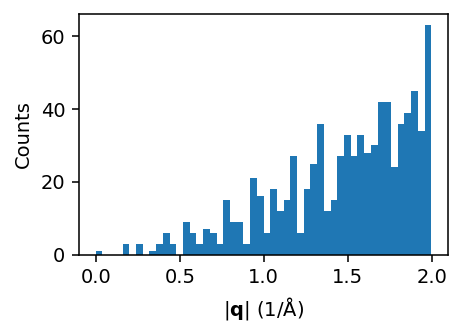

In [6]:
plt.figure(figsize=(3.4, 2.5), dpi=140)
plt.hist(np.linalg.norm(q_points, axis=1), bins=50)
plt.xlabel(r'$|\mathbf{q}|$ (1/Å)')
plt.ylabel('Counts')
plt.tight_layout()

## Run calculation of correlation functions

We are now all set for calculating the dynamic structure factor as well as the current correlation functions (by setting `include_currents=True`).
To obtain the correct units, the spacing between the frames (`dt`) must be specified in units of femtoseconds.

The following cell should take a few minutes to run on a common work station.

In [7]:
%%time
sample_raw = compute_dynamic_structure_factors(
    traj, q_points, dt=25.0, window_size=500,
    window_step=50, calculate_currents=True)

INFO: Spacing between samples (frame_step): 1
INFO: Time between consecutive frames in input trajectory (dt): 25.0 fs
INFO: Time between consecutive frames used (dt * frame_step): 25.0 fs
INFO: Time window size (dt * frame_step * window_size): 12500.0 fs
INFO: Angular frequency resolution: dw = 0.000503 2pi/fs = 0.331 meV
INFO: Maximum angular frequency (dw * window_size): 0.251327 2pi/fs = 165.427 meV
INFO: Nyquist angular frequency (2pi / frame_step / dt / 2): 0.126 2pi/fs = 82.7 meV
INFO: Calculating current (velocity) correlations
INFO: Number of q-points: 820
CPU times: user 7min 33s, sys: 1.04 s, total: 7min 34s
Wall time: 1min 4s


As in the case of the trajectory, we can use the `display` or `print` commands to obtain a quick summary of the [Sample object](https://dynasor.materialsmodeling.org/sample.html) returned by the [compute_dynamic_structure_factors function](https://dynasor.materialsmodeling.org/interface_python/correlation_functions.html).

In [8]:
display(sample_raw)

DynamicSample
Atom types: ['X']
Pairs: [('X', 'X')]
Particle counts: {'X': 2048}
Simulations cell:
[[34.032  0.     0.   ]
 [ 0.    34.032  0.   ]
 [ 0.     0.    34.032]]
q_points        with shape: (820, 3)
time            with shape: (501,)
omega           with shape: (501,)
Fqt_coh_X_X     with shape: (820, 501)
Sqw_coh_X_X     with shape: (820, 501)
Fqt_coh         with shape: (820, 501)
Sqw_coh         with shape: (820, 501)
Clqt_X_X        with shape: (820, 501)
Ctqt_X_X        with shape: (820, 501)
Clqw_X_X        with shape: (820, 501)
Ctqw_X_X        with shape: (820, 501)
Clqt            with shape: (820, 501)
Ctqt            with shape: (820, 501)
Clqw            with shape: (820, 501)
Ctqw            with shape: (820, 501)
Fqt             with shape: (820, 501)
Sqw             with shape: (820, 501)

## Spherical average over **q**-points

It is often of interest to take a spherical average over **q**-space, in particular in the case of liquids.
To this end, we use the [get_bin_spherical_averaged_sample function](https://dynasor.materialsmodeling.org/dev/interface_python.html#dynasor.post_processing.get_bin_spherical_averaged_sample).

In [9]:
sample_averaged = get_bin_spherical_averaged_sample(sample_raw, num_q_bins=40)

## Visualize dynamic structure factor

We can now visualize the isotropically averaged dynamic structure factor $S(|\mathbf{q}|, \omega)$, for example, in the form of a heatmap on the momentum-frequency plane.
Note that the lower cutoff of the **q**-axis is set by the size of the supercell.

In [10]:
conversion_factor = 658.2119  # conversion from 1/fs to meV
sample_averaged.omega *= conversion_factor

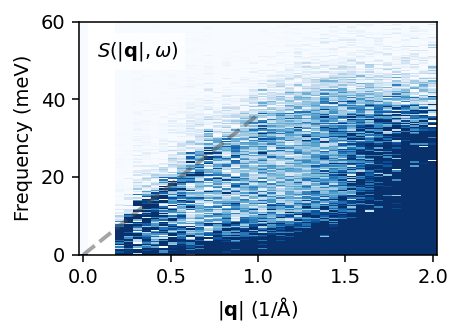

In [11]:
fig, ax = plt.subplots(figsize=(3.4, 2.5), dpi=140)

ax.pcolormesh(sample_averaged.q_norms, sample_averaged.omega,
              sample_averaged.Sqw_coh.T,
              cmap='Blues', vmin=0, vmax=4)
ax.text(0.05, 0.85, '$S(|\mathbf{q}|, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})
ax.plot([0, 1], [0, 36], alpha=0.5, ls='--', c='0.3', lw=2)

ax.set_xlabel('$|\mathbf{q}|$ (1/Å)')
ax.set_ylabel('Frequency (meV)')
ax.set_ylim([0, 60])

fig.tight_layout()

### Visualize current correlations

Next we plot the longitudinal and transverse current correlation heatmaps.
In the longitudinal current correlation function one can observe the longitudinal branch that is also visible in the dynamic structure factor.
The transverse current correlation functions also reveals a transverse mode.

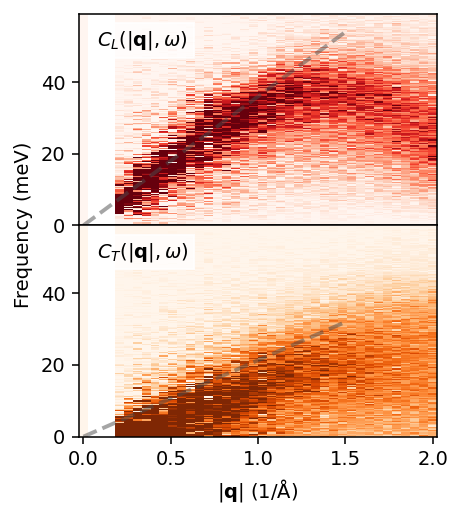

In [12]:
fig, axes = plt.subplots(figsize=(3.4, 3.8), nrows=2, dpi=140,
                         sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(sample_averaged.q_norms, sample_averaged.omega,
              sample_averaged.Clqw.T, cmap='Reds', vmin=0, vmax=4000)
ax.text(0.05, 0.85, '$C_L(|\mathbf{q}|, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})
ax.plot([0, 1.5], [0, 54], alpha=0.5, ls='--', c='0.3', lw=2)

ax = axes[1]
ax.pcolormesh(sample_averaged.q_norms, sample_averaged.omega,
              sample_averaged.Ctqw.T, cmap='Oranges', vmin=0, vmax=4000)
ax.text(0.05, 0.85, '$C_T(|\mathbf{q}|, \omega)$', transform=ax.transAxes,
        bbox={'color': 'white', 'alpha': 0.8, 'pad': 3})
ax.plot([0, 1.5], [0, 32], alpha=0.5, ls='--', c='0.3', lw=2)

ax.set_xlabel('$|\mathbf{q}|$ (1/Å)')
ax.set_ylabel('Frequency (meV)', y=1)
ax.set_ylim([0, 59])

fig.tight_layout()
plt.subplots_adjust(hspace=0)

## Slices in |**q**|-space

Finally, we can also inspect individually slices as demonstrated in the following cell.

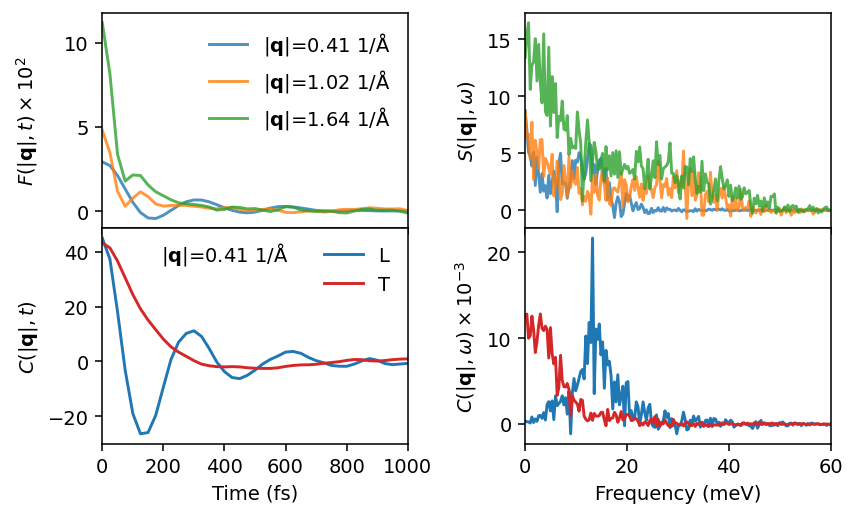

In [13]:
q_inds = [8, 20, 32]  # slices in heatmap

fig, axes = plt.subplots(figsize=(6.2, 3.8), nrows=2, ncols=2,
                         sharex='col', dpi=140)

#-----
# Intermediate scattering function and dynamic structure factor
for q_ind in q_inds:
    label = fr'$|\mathbf{{q}}|$={sample_averaged.q_norms[q_ind]:.2f} 1/Å'
    axes[0][0].plot(sample_averaged.time, sample_averaged.Fqt[q_ind, :] * 100,
                    label=label, alpha=0.8)
    axes[0][1].plot(sample_averaged.omega, sample_averaged.Sqw[q_ind, :],
                    label=label, alpha=0.8)

ax = axes[0][0]
ax.set_ylabel(r'$F(|\mathbf{q}|, t) \times 10^2$')
ax.legend(frameon=False)

ax = axes[0][1]
ax.set_ylabel('$S(|\mathbf{q}|, \omega)$')

#-----
# Current correlation functions
q_ind = q_inds[0]
axes[1][0].plot(sample_averaged.time, sample_averaged.Clqt[q_ind, :],
                label='L')
axes[1][0].plot(sample_averaged.time, sample_averaged.Ctqt[q_ind, :],
                label='T', c='C3')
axes[1][1].plot(sample_averaged.omega, sample_averaged.Clqw[q_ind, :] / 1000,
                label='L')
axes[1][1].plot(sample_averaged.omega, sample_averaged.Ctqw[q_ind, :] / 1000,
                label='T', c='C3')

ax = axes[1][0]
ax.set_xlabel('Time (fs)')
ax.set_xlim([0, 1000])
ax.set_ylabel('$C(|\mathbf{q}|, t)$')
ax.legend(frameon=False)
ax.text(0.4, 0.85, fr'$|\mathbf{{q}}|$={sample_averaged.q_norms[q_ind]:.2f} 1/Å',
        ha='center', transform=ax.transAxes)

ax = axes[1][1]
ax.set_xlabel('Frequency (meV)')
ax.set_xlim([0, 60])                 
ax.set_ylabel(r'$C(|\mathbf{q}|, \omega) \times 10^{-3}$')
                 
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.align_ylabels(axes)